## Topic modelling  

The purpose of this notebook is to understand more precisely which topic is recurrent in the podcast, using topic modelling method.

### I. Set up

In [27]:
conda install -c conda-forge gensim

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
from gensim import matutils, models
import scipy.sparse
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pickle
import pandas as pd
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv('dfguestdataeda.csv')
df.head()

,Unnamed: 0,date,guest,duration,text
0,13,2020-05-13,Tom Papa,3:14:57,"""hello. friends, welcome to the show this up, ..."
1,16,2020-05-07,Tony Hinchcliffe,3:07:32,"hello, friends. welcome to the show this episo..."
2,23,2020-04-25,Duncan Trussell,3:17:17,"oh hello, friends, welcome to the show this ep..."
3,36,2020-04-02,Greg Fitzsimmons,3:21:42,hey friends. welcome to the show this episode ...
4,38,2020-03-31,Brian Redban,3:31:47,"hello, friends, and welcome to the show this e..."


In [3]:
add_stop_words = ['like', 'im','guy','hi','ha','kind','want', 'man','good','great','sort','sort of','oh','probably','real',
                  'lot','of','lot of','kind of','doing','way','come','saying','maybe','better','stuff','use','yes',
                  'ok','mean','did','going', 'know', 'make', 'day','gotta', 'let', 'need','doe', 'theyre',
                  'just', 'dont', 'thats', 'right', 'people','youre', 'got','thing','thing ','look','yes ','didnt ','actually ',
                  'say','does','really', 'gonna', 'time', 'think', 'yeah','ive','year', 'said', ' way',' yeah',
                  'thats','people','think', 'right', 'really', 'got', 'im','right','know', 'think', ' fucking',' theres',
                  'gon','fuckin','fuck', 'shit', 'shes', 'fucking', 'guess','theres','hes', 'things', 'guys','point', 'hey', 'body','fight']
# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

### III. Topic Modelling on the whole text

In [40]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df.index
data = data_dtm.transpose()

In [41]:
sparse_counts = scipy.sparse.csr_matrix(data)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [42]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [43]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=8, passes=20)
lda.print_topics()

2020-06-13 11:13:15,046 : INFO : using symmetric alpha at 0.125
2020-06-13 11:13:15,049 : INFO : using symmetric eta at 0.125
2020-06-13 11:13:15,065 : INFO : using serial LDA version on this node
2020-06-13 11:13:15,115 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 114 documents, updating model once every 114 documents, evaluating perplexity every 114 documents, iterating 50x with a convergence threshold of 0.001000
2020-06-13 11:13:18,363 : INFO : -11.149 per-word bound, 2271.3 perplexity estimate based on a held-out corpus of 114 documents with 293507 words
2020-06-13 11:13:18,365 : INFO : PROGRESS: pass 0, at document #114/114
2020-06-13 11:13:19,002 : INFO : topic #1 (0.125): 0.043*"like" + 0.014*"know" + 0.014*"yeah" + 0.013*"thats" + 0.012*"just" + 0.011*"think" + 0.010*"people" + 0.009*"im" + 0.009*"dont" + 0.007*"right"
2020-06-13 11:13:19,005 : INFO : topic #2 (0.125): 0.030*"like" + 0.017*"just" + 0.016*"know" + 0.011*"rig

[(0,
  '0.008*"know" + 0.007*"right" + 0.007*"years" + 0.006*"thousand" + 0.004*"like" + 0.004*"think" + 0.004*"ago" + 0.003*"look" + 0.003*"thats" + 0.003*"did"'),
 (1,
  '0.023*"like" + 0.009*"just" + 0.008*"thats" + 0.007*"yeah" + 0.007*"im" + 0.006*"right" + 0.006*"know" + 0.005*"dont" + 0.005*"people" + 0.004*"think"'),
 (2,
  '0.011*"know" + 0.009*"just" + 0.008*"thats" + 0.007*"like" + 0.006*"dont" + 0.005*"right" + 0.004*"people" + 0.004*"hunting" + 0.004*"got" + 0.004*"im"'),
 (3,
  '0.000*"like" + 0.000*"just" + 0.000*"yeah" + 0.000*"im" + 0.000*"dont" + 0.000*"thats" + 0.000*"think" + 0.000*"know" + 0.000*"really" + 0.000*"right"'),
 (4,
  '0.037*"like" + 0.015*"just" + 0.014*"know" + 0.011*"thats" + 0.011*"people" + 0.009*"think" + 0.009*"right" + 0.008*"dont" + 0.007*"yeah" + 0.007*"really"'),
 (5,
  '0.045*"like" + 0.024*"know" + 0.018*"yeah" + 0.017*"just" + 0.013*"people" + 0.012*"thats" + 0.011*"dont" + 0.011*"think" + 0.010*"right" + 0.009*"im"'),
 (6,
  '0.000*"like"

### IV. Topic modelling using only the name

In [44]:
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [45]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [46]:
data_nouns = pd.DataFrame(df.text.apply(nouns))

In [47]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.text)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index

C:\Users\benja\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actually', 'didnt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [48]:
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [49]:
ldan = models.LdaModel(corpus=corpusn, num_topics=8, id2word=id2wordn, passes=20)
ldan.print_topics()

2020-06-13 11:16:04,759 : INFO : using symmetric alpha at 0.125
2020-06-13 11:16:04,761 : INFO : using symmetric eta at 0.125
2020-06-13 11:16:04,777 : INFO : using serial LDA version on this node
2020-06-13 11:16:04,815 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 114 documents, updating model once every 114 documents, evaluating perplexity every 114 documents, iterating 50x with a convergence threshold of 0.001000
2020-06-13 11:16:06,728 : INFO : -11.338 per-word bound, 2588.4 perplexity estimate based on a held-out corpus of 114 documents with 103514 words
2020-06-13 11:16:06,731 : INFO : PROGRESS: pass 0, at document #114/114
2020-06-13 11:16:07,242 : INFO : topic #4 (0.125): 0.006*"years" + 0.005*"money" + 0.004*"life" + 0.003*"world" + 0.003*"kids" + 0.003*"work" + 0.003*"com" + 0.003*"everybody" + 0.003*"idea" + 0.003*"person"
2020-06-13 11:16:07,244 : INFO : topic #0 (0.125): 0.006*"years" + 0.004*"life" + 0.004*"money" + 0.

[(0,
  '0.005*"years" + 0.005*"life" + 0.004*"world" + 0.004*"money" + 0.004*"work" + 0.004*"game" + 0.004*"person" + 0.003*"idea" + 0.003*"brain" + 0.003*"night"'),
 (1,
  '0.004*"life" + 0.004*"years" + 0.004*"sense" + 0.003*"book" + 0.003*"person" + 0.003*"world" + 0.003*"work" + 0.003*"idea" + 0.003*"women" + 0.003*"money"'),
 (2,
  '0.004*"years" + 0.004*"money" + 0.004*"life" + 0.004*"everybody" + 0.004*"world" + 0.004*"game" + 0.004*"person" + 0.003*"place" + 0.003*"god" + 0.003*"car"'),
 (3,
  '0.011*"years" + 0.004*"feet" + 0.003*"everybody" + 0.003*"life" + 0.003*"idea" + 0.003*"money" + 0.003*"brain" + 0.003*"times" + 0.003*"space" + 0.002*"book"'),
 (4,
  '0.009*"years" + 0.006*"money" + 0.004*"life" + 0.004*"cause" + 0.004*"com" + 0.003*"everybody" + 0.003*"kids" + 0.003*"person" + 0.003*"job" + 0.003*"world"'),
 (5,
  '0.005*"years" + 0.004*"life" + 0.003*"idea" + 0.003*"phone" + 0.003*"world" + 0.003*"problem" + 0.003*"money" + 0.003*"place" + 0.003*"work" + 0.003*"god"'

### V. Topic Modelling using name and adjectives

In [50]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [51]:
data_nouns_adj = pd.DataFrame(df.text.apply(nouns_adj))

In [52]:
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index

In [53]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [54]:
ldana = models.LdaModel(corpus=corpusna, num_topics=8, id2word=id2wordna, passes=20)
ldana.print_topics()

2020-06-13 11:18:51,293 : INFO : using symmetric alpha at 0.125
2020-06-13 11:18:51,296 : INFO : using symmetric eta at 0.125
2020-06-13 11:18:51,316 : INFO : using serial LDA version on this node
2020-06-13 11:18:51,386 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 114 documents, updating model once every 114 documents, evaluating perplexity every 114 documents, iterating 50x with a convergence threshold of 0.001000
2020-06-13 11:18:55,343 : INFO : -11.508 per-word bound, 2911.7 perplexity estimate based on a held-out corpus of 114 documents with 123903 words
2020-06-13 11:18:55,346 : INFO : PROGRESS: pass 0, at document #114/114
2020-06-13 11:18:55,937 : INFO : topic #7 (0.125): 0.002*"somebody" + 0.002*"car" + 0.002*"head" + 0.002*"game" + 0.002*"job" + 0.002*"thirty" + 0.002*"kids" + 0.002*"brain" + 0.002*"ill" + 0.002*"end"
2020-06-13 11:18:55,940 : INFO : topic #1 (0.125): 0.002*"brain" + 0.002*"problem" + 0.002*"ass" + 0.002*"

[(0,
  '0.003*"job" + 0.003*"house" + 0.002*"kids" + 0.002*"thirty" + 0.002*"night" + 0.002*"dollars" + 0.002*"car" + 0.002*"head" + 0.002*"friends" + 0.002*"couple"'),
 (1,
  '0.002*"brain" + 0.002*"problem" + 0.002*"kids" + 0.002*"studies" + 0.002*"human" + 0.002*"women" + 0.002*"food" + 0.002*"free" + 0.002*"important" + 0.002*"wrong"'),
 (2,
  '0.006*"game" + 0.004*"games" + 0.003*"video" + 0.003*"tv" + 0.003*"strike" + 0.002*"comedy" + 0.002*"phone" + 0.002*"box" + 0.002*"team" + 0.002*"mind"'),
 (3,
  '0.003*"tough" + 0.003*"head" + 0.002*"round" + 0.002*"sport" + 0.002*"phone" + 0.002*"boy" + 0.002*"fighters" + 0.002*"power" + 0.002*"somebody" + 0.002*"ass"'),
 (4,
  '0.002*"women" + 0.002*"fights" + 0.002*"week" + 0.002*"funny" + 0.002*"rogan" + 0.002*"head" + 0.002*"ass" + 0.002*"somebody" + 0.002*"brain" + 0.002*"night"'),
 (5,
  '0.004*"car" + 0.003*"house" + 0.003*"night" + 0.003*"dollars" + 0.002*"funny" + 0.002*"dude" + 0.002*"bunch" + 0.002*"water" + 0.002*"super" + 0.00

try with biagram

In [4]:
# natural language processing: n-gram ranking
import re
import unicodedata
import nltk
from nltk.corpus import stopwords # add appropriate words that will be ignored in the analysis
import matplotlib.pyplot as plt

In [5]:
nltk.download('wordnet_ic')

[nltk_data] Downloading package wordnet_ic to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


True

In [16]:
from nltk.corpus import wordnet

In [18]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [19]:
nltk.corpus.wordnet

<WordNetCorpusReader in 'C:\\Users\\benja\\AppData\\Roaming\\nltk_data\\corpora\\wordnet'>

In [147]:
add_stop_words = ['like', 'im','guy','hi','ha','kind','want', 'man','good','great','sort','sort of','oh',
                  'probably','real','hundred','thousand','slash','rogan','code','word','dot','com',
                  'lot','of','lot of','kind of','doing','way','come','saying','maybe','better','stuff','use','yes',
                  'ok','mean','did','going', 'know', 'make', 'day','gotta', 'let', 'need','doe', 'theyre',
                  'just', 'dont', 'thats', 'right', 'people','youre', 'got','thing','thing ','look','yes ',
                  'didnt ','actually ','even ','make ','sense ','years ','ago ','go ','see ','damm ',
                  'say','does','really', 'gonna', 'time', 'think', 'yeah','ive','year', 'said', ' way',' yeah',
                  'thats','people','think', 'right', 'really', 'got', 'im','right','know', 'think', ' fucking',
                  ' theres','joe', 'save', 'percent','new', 'york', 'city', 'friend', 'welcome', 'show', 
                  'hello', 'friend', 'welcome','podcast', 'brought', 'buy','episode', 'podcast', 'brought',
                  'go', 'back', 'forth','ever', 'seen', 'life','dumb', 'many', 'first','little','bit',
                  'gon','fuckin','fuck', 'shit', 'shes', 'fucking', 'guess','theres','hes', 'things', 'guys',
                  'point', 'hey', 'body','fight','could','see','twenty', 'year', 'old','twenty','years','old',
                  'dont','know','one', 'two', 'tree', 'four', 'five','six','seven', 'eight', 'nine','ten',
                  'get', 'would','hundred','j', 'r', 'e','space', 'square','couple', 'day', 'ago'
                  'dollar', 'shave', 'club','download', 'cash', 'app','dollar', 'bonus', 'offer','love',
                  'pretty', 'god', 'damn', 'much', 'love', 'bye','blah','woah','whats','thank', 'thank', 'everybody']


In [148]:
ADDITIONAL_STOPWORDS = add_stop_words

In [149]:
def basic_clean(text):

  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [150]:
words = basic_clean(''.join(str(df['text'].tolist())))

In [151]:
(pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

(make, sense)        56
(even, though)       55
(million, dollar)    49
(lady, gentleman)    48
(mother, fucker)     48
(united, state)      43
(video, game)        42
(high, school)       41
(high, level)        40
(human, being)       40
(jesus, christ)      39
(every, single)      37
(cant, cant)         30
(doesnt, matter)     30
(take, care)         29
(somebody, else)     29
(martial, art)       28
(three, month)       28
(social, medium)     27
(cant, believe)      27
dtype: int64

In [154]:
(pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

(strength, conditioning, equipment)    15
(bad, mother, fucker)                  10
(top, food, chain)                     10
(playing, video, game)                  8
(performance, enhancing, drug)          8
(william, randolph, hearst)             7
(rennes, forgotten, charity)            7
(purchase, website, domain)             6
(black, life, matter)                   6
(traumatic, brain, injury)              6
(total, human, optimization)            6
(drop, user, interface)                 5
(job, gain, experience)                 5
(charity, building, well)               5
(click, academy, link)                  5
(grass, fed, beef)                      5
(roy, jones, junior)                    5
(weight, loss, challenge)               5
(win, win, win)                         5
(building, well, pygmy)                 5
dtype: int64

In [155]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

Text(0.5, 0, '# of Occurances')

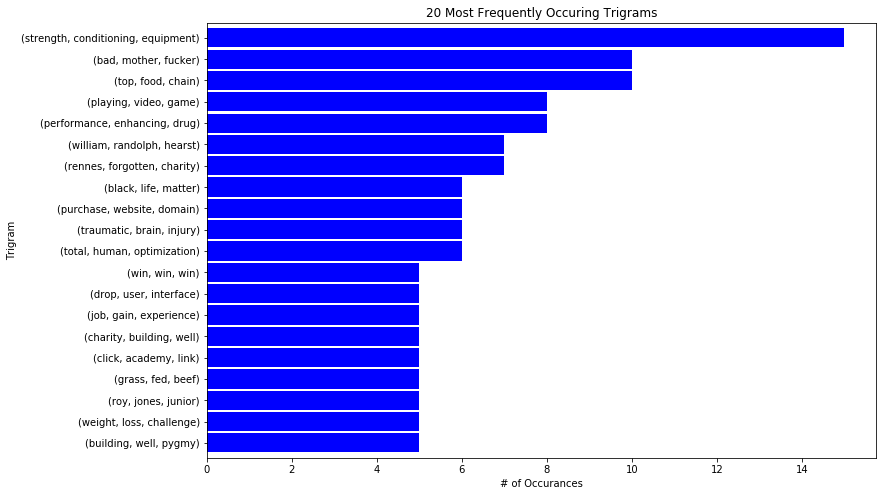

In [156]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

In [193]:
trigram_df = pd.DataFrame(trigrams_series, columns=['count'])

trigram_df.reset_index(inplace=True)
trigram_df

,index,count
0,"(strength, conditioning, equipment)",15
1,"(bad, mother, fucker)",10
2,"(top, food, chain)",10
3,"(playing, video, game)",8
4,"(performance, enhancing, drug)",8
5,"(william, randolph, hearst)",7
6,"(rennes, forgotten, charity)",7
7,"(purchase, website, domain)",6
8,"(black, life, matter)",6
9,"(traumatic, brain, injury)",6


In [196]:
import networkx as nx

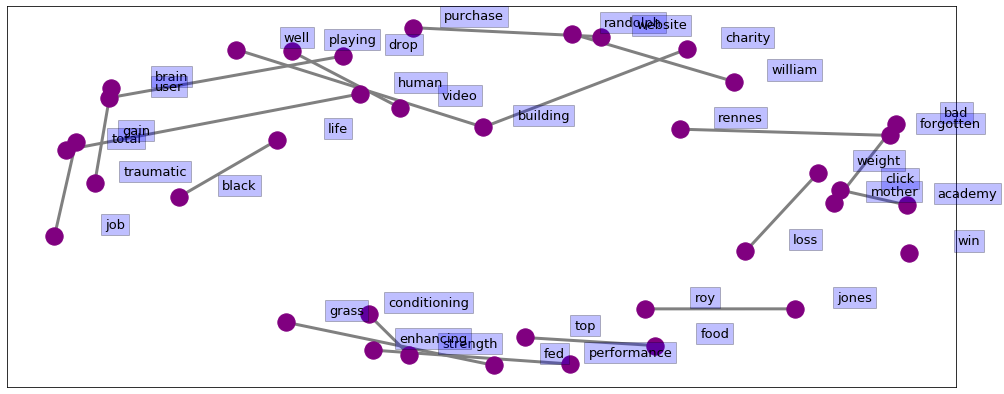

In [216]:
# Create dictionary of bigrams and their counts
d = trigram_df.set_index('index').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 4))

fig, ax = plt.subplots(figsize=(17, 7))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='blue', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()